In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd

In [2]:
df = pd.read_csv("~/Downloads/BTCUSDT_1M_500000.csv")
print(df.head())

    symbol interval       openTime     open     high      low    close  \
0  BTCUSDT       1m  1525916940000  9320.00  9323.00  9317.36  9317.38   
1  BTCUSDT       1m  1525917000000  9322.17  9322.17  9317.38  9322.17   
2  BTCUSDT       1m  1525917060000  9317.38  9321.00  9311.11  9315.00   
3  BTCUSDT       1m  1525917120000  9314.98  9315.00  9311.16  9314.98   
4  BTCUSDT       1m  1525917180000  9314.98  9314.99  9308.58  9313.00   

      volume      closeTime  quoteAssetVolume  trades  baseAssetVolume  
0  10.119046  1525916999999      70150.071657      69         7.525355  
1   8.146668  1525917059999      57162.915003      59         6.132797  
2   9.031244  1525917119999      49845.846513      80         5.350805  
3  16.624334  1525917179999     131878.645994      66        14.157843  
4  14.399353  1525917239999      94041.092660     106        10.097646  


In [3]:
rdf = torch.Tensor(np.array(df[['open']]))
rdf = (rdf-rdf.mean(0))/rdf.std()
rdf = rdf.reshape(-1,500000)
print(rdf)

tensor([[2.4105, 2.4119, 2.4088,  ..., 0.0118, 0.0129, 0.0077]])


In [4]:
m=450000
x_train = rdf[:,:m]
x_test = rdf[:,m:]

In [5]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, n_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.rnn = torch.nn.LSTM(input_size,hidden_size, n_layers, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)
    def forward(self, x):
        output, hidden = self.rnn(x.view(len(x),1,-1))
        y_pred = self.linear(output[-1].view(1,-1))
        return y_pred.view(-1)
    def init_hidden(self):
        return(torch.zeros(self.n_layers, 1, self.hidden_size),torch.zeros(self.n_layers, 1, self.hidden_size))


In [6]:
lr = 0.001
no_epochs = 2
model = RNN(450000, 512, 50000,1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


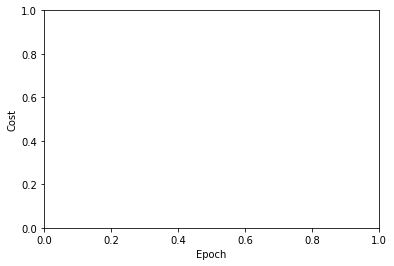

tensor(0.3386, grad_fn=<MseLossBackward>)
tensor(0.2949, grad_fn=<MseLossBackward>)
Epoch 2 Cost tensor(0.2949, grad_fn=<MseLossBackward>)


In [11]:
costs = []
plt.ion()
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
ax.set_xlim(0,no_epochs-1)
plt.show()

def train(no_epochs):
    for epoch in range(no_epochs):
        h = model.init_hidden()
        out = model.forward(x_train)
        out.view(-1,50000,1)
        out = out.unsqueeze(0)
        cost = criterion(out,x_test)
        print(cost)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        costs.append(cost.item())
    ax.plot(costs,'b')
    fig.canvas.draw()
    print('Epoch', epoch+1, 'Cost', cost)
train(no_epochs)
                

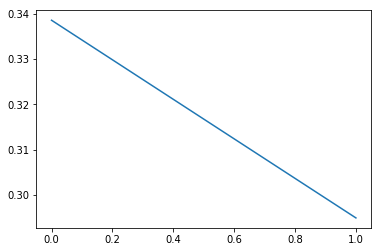